In [1]:
# Colab setup: install deps
!pip -q install pandas numpy matplotlib plotly==5.20.0 sodapy python-dateutil


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 60.9 MB/s eta 0:00:00


In [3]:
from google.colab import files
import io, pandas as pd

uploaded = files.upload()  # <- pick your NASA Global Landslide Catalog CSV
fname = next(iter(uploaded))  # first (or only) uploaded file

# Try robust CSV loading
try:
    df = pd.read_csv(io.BytesIO(uploaded[fname]), low_memory=False)
except UnicodeDecodeError:
    df = pd.read_csv(io.BytesIO(uploaded[fname]), low_memory=False, encoding="latin1")

print("Loaded:", fname, "| Rows:", len(df))
print("Columns:", list(df.columns)[:25])
df.head(3)


Saving Global_Landslide_Catalog_Export_rows.csv to Global_Landslide_Catalog_Export_rows.csv
Loaded: Global_Landslide_Catalog_Export_rows.csv | Rows: 11033
Columns: ['source_name', 'source_link', 'event_id', 'event_date', 'event_time', 'event_title', 'event_description', 'location_description', 'location_accuracy', 'landslide_category', 'landslide_trigger', 'landslide_size', 'landslide_setting', 'fatality_count', 'injury_count', 'storm_name', 'photo_link', 'notes', 'event_import_source', 'event_import_id', 'country_name', 'country_code', 'admin_division_name', 'admin_division_population', 'gazeteer_closest_point']


,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
0,AGU,https://blogs.agu.org/landslideblog/2008/10/14...,684,08/01/2008 12:00:00 AM,NaN,"Sigou Village, Loufan County, Shanxi Province","occurred early in morning, 11 villagers buried...","Sigou Village, Loufan County, Shanxi Province",unknown,landslide,...,CN,Shaanxi,0.0,Jingyang,41.02145,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,107.4500,32.5625
1,Oregonian,http://www.oregonlive.com/news/index.ssf/2009/...,956,01/02/2009 02:00:00 AM,NaN,"Lake Oswego, Oregon",Hours of heavy rain are to blame for an overni...,"Lake Oswego, Oregon",5km,mudslide,...,US,Oregon,36619.0,Lake Oswego,0.60342,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-122.6630,45.4200
2,CBS News,https://www.cbsnews.com/news/dozens-missing-af...,973,01/19/2007 12:00:00 AM,NaN,"San Ramon district, 195 miles northeast of the...",(CBS/AP) At least 10 people died and as many a...,"San Ramon district, 195 miles northeast of the...",10km,landslide,...,PE,Junín,14708.0,San Ramón,0.85548,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-75.3587,-11.1295


In [4]:
import numpy as np
from dateutil import parser

# normalize column names
df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(r"[^a-z0-9]+", "_", regex=True))

def pick(cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

date_col    = pick(["event_date","date","event_date_dt","date_"])
country_col = pick(["country","countryname","country_name"])
trigger_col = pick(["trigger","landslide_trigger","landslide__trigger","landslide_trigger_"])
fatal_col   = pick(["fatality_count","fatalities","fatality","fatalities_count"])
city_col    = pick(["nearest_places","location_description","admin_division_name","gazeteer_closest"])
lat_col     = pick(["latitude","lat"])
lon_col     = pick(["longitude","lon","long"])

required = [date_col, country_col, trigger_col, fatal_col]
if any(c is None for c in required):
    raise ValueError(f"Missing a key column. Resolved:\n"
                     f"date={date_col}, country={country_col}, trigger={trigger_col}, fatalities={fatal_col}\n"
                     f"Available: {df.columns.tolist()}")

def parse_date_safe(x):
    try: return parser.parse(str(x))
    except: return pd.NaT

df["event_dt"] = df[date_col].apply(parse_date_safe)
df = df.dropna(subset=["event_dt"]).copy()

# tidy fields
df[country_col] = df[country_col].astype(str).str.strip()
df[trigger_col] = df[trigger_col].astype(str).str.strip()
df[fatal_col]   = pd.to_numeric(df[fatal_col], errors="coerce").fillna(0).astype(int)

df["year"] = df["event_dt"].dt.year
df["month"] = df["event_dt"].dt.month
df["month_name"] = df["event_dt"].dt.month_name()

df[[date_col, country_col, trigger_col, fatal_col]].head()


,event_date,country_name,landslide_trigger,fatality_count
0,08/01/2008 12:00:00 AM,China,rain,11
1,01/02/2009 02:00:00 AM,United States,downpour,0
2,01/19/2007 12:00:00 AM,Peru,downpour,10
3,07/31/2009 12:00:00 AM,Nepal,monsoon,1
4,10/16/2010 12:00:00 PM,Philippines,tropical_cyclone,0


In [5]:
# handle TURKIYE/TÜRKIYE spellings
country_series = df[country_col].str.upper().str.replace("İ","I")
mask_turkey = country_series.str.contains(r"\bTURKEY\b|\bTURKIYE\b|\bTURKIYE CUMHURIYETI\b|\bTÜRKIYE\b", regex=True)

tur = df[mask_turkey].copy()
print("Turkey rows:", len(tur))
tur.head(3)


Turkey rows: 21


,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude,event_dt,year,month,month_name
971,google,http://www.google.com/hostednews/ap/article/AL...,1189,09/23/2009 08:00:00 PM,NaN,"Borcka, in Artvin province",The Anatolia news agency says three people wer...,"Borcka, in Artvin province",10km,landslide,...,0.79004,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,41.6822,41.3639,2009-09-23 20:00:00,2009,9,September
1155,www.foxnews.com,http://www.foxnews.com/world/2013/07/19/landsl...,5112,07/16/2013 08:00:00 AM,NaN,"Near Dortyol, Hatay, On The Turkey-Syria Border",An official says a landslide triggered by heav...,"Near Dortyol, Hatay, On The Turkey-Syria Border",25km,landslide,...,8.45189,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,36.4354,36.7619,2013-07-16 08:00:00,2013,7,July
1224,Daily Sabah,http://www.dailysabah.com/nation/2015/08/24/de...,7775,08/24/2015 12:00:00 AM,NaN,"Hopa, Artvin","Victims were residents of villages in Hopa, a ...","Hopa, Artvin",50km,landslide,...,1.11321,06/16/2016 10:15:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,41.4323,41.3936,2015-08-24 00:00:00,2015,8,August


In [6]:
import pandas as pd

# Show the full table (not just first 5 rows)
# If dataset is small you can display it directly
from IPython.display import display

display(tur)   # will render the full DataFrame as a scrollable table in Colab


,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude,event_dt,year,month,month_name
971,google,http://www.google.com/hostednews/ap/article/AL...,1189,09/23/2009 08:00:00 PM,NaN,"Borcka, in Artvin province",The Anatolia news agency says three people wer...,"Borcka, in Artvin province",10km,landslide,...,0.79004,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,41.6822,41.3639,2009-09-23 20:00:00,2009,9,September
1155,www.foxnews.com,http://www.foxnews.com/world/2013/07/19/landsl...,5112,07/16/2013 08:00:00 AM,NaN,"Near Dortyol, Hatay, On The Turkey-Syria Border",An official says a landslide triggered by heav...,"Near Dortyol, Hatay, On The Turkey-Syria Border",25km,landslide,...,8.45189,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,36.4354,36.7619,2013-07-16 08:00:00,2013,7,July
1224,Daily Sabah,http://www.dailysabah.com/nation/2015/08/24/de...,7775,08/24/2015 12:00:00 AM,NaN,"Hopa, Artvin","Victims were residents of villages in Hopa, a ...","Hopa, Artvin",50km,landslide,...,1.11321,06/16/2016 10:15:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,41.4323,41.3936,2015-08-24 00:00:00,2015,8,August
2030,turkishpress,http://www.turkishpress.com/news.asp?id=251402,783,09/09/2008 12:00:00 AM,NaN,Ormonli village of Sirvan town of Siirt province,heavy rain loosened soil and caused landslide ...,Ormonli village of Sirvan town of Siirt province,25km,landslide,...,5.52188,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,41.5061,37.9472,2008-09-09 00:00:00,2008,9,September
2319,Daily Sabah,http://www.dailysabah.com/nation/2016/07/09/bl...,8891,07/07/2016 11:00:00 PM,NaN,"Trabzon Province, Turkey",Floods and landslides triggered by the heavy r...,"Trabzon Province, Turkey",50km,mudslide,...,9.89517,07/11/2016 04:52:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,39.9081,40.8167,2016-07-07 23:00:00,2016,7,July
2608,todayszaman,http://www.todayszaman.com/tz-web/news-186867-...,1152,09/09/2009 12:00:00 AM,NaN,"Cebeci Cemetery, Istanbul?",A mudslide caused by Wednesday's floods has da...,"Cebeci Cemetery, Istanbul?",5km,mudslide,...,0.59839,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,28.9759,41.0124,2009-09-09 00:00:00,2009,9,September
2700,www.globaltimes.cn,http://www.globaltimes.cn/content/766867.shtml,4770,03/07/2013 12:00:00 AM,NaN,Hakkari,Four members of the outlawed Kurdish Workers' ...,Hakkari,5km,landslide,...,0.28892,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,43.6143,37.2506,2013-03-07 00:00:00,2013,3,March
2780,doomdaily,http://www.doomdaily.com/2009/landslide-asia-t...,1321,11/21/2009 12:00:00 AM,NaN,Black Sea port city of Trabzon A Northern prov...,Landslides devastated several houses in northe...,Black Sea port city of Trabzon A Northern prov...,5km,landslide,...,2.97588,09/11/2014 08:09:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,39.7365,40.9792,2009-11-21 00:00:00,2009,11,November
2958,sports.ndtv.com,http://sports.ndtv.com/football/news/202642-se...,4736,01/27/2013 12:00:00 AM,NaN,"Diyarbakir, Turkey",At least seven people were killed late Sunday ...,"Diyarbakir, Turkey",25km,landslide,...,1.03218,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,40.2306,37.9152,2013-01-27 00:00:00,2013,1,January
3406,todayszaman,http://www.todayszaman.com/tz-web/detaylar.do?...,821,09/28/2008 12:00:00 AM,NaN,"Sakarya, Hendek village","After two days of torrential rainfall, Sakary...","Sakarya, Hendek village",50km,landslide,...,8.71240,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,30.4580,40.6900,2008-09-28 00:00:00,2008,9,September


In [7]:
# Select the columns you’ll need in SQL
cols = ["event_id", "event_dt", "landslide_trigger", "admin_division_name",
        "fatality_count", "longitude", "latitude"]

tur_export = tur[cols].copy()
tur_export["event_date"] = tur_export["event_dt"].dt.strftime("%Y-%m-%d")  # string for MySQL DATE
tur_export.drop(columns=["event_dt"], inplace=True)

# Save CSV (downloadable in Colab)
tur_export.to_csv("landslides_tr.csv", index=False)


In [ ]:
from google.colab import files
files.download("landslides_tr.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,month,events,month_name
0,1,1,January
1,3,1,March
2,4,1,April
3,5,1,May
4,7,4,July
5,8,4,August
6,9,5,September
7,11,4,November


<Figure size 640x480 with 0 Axes>

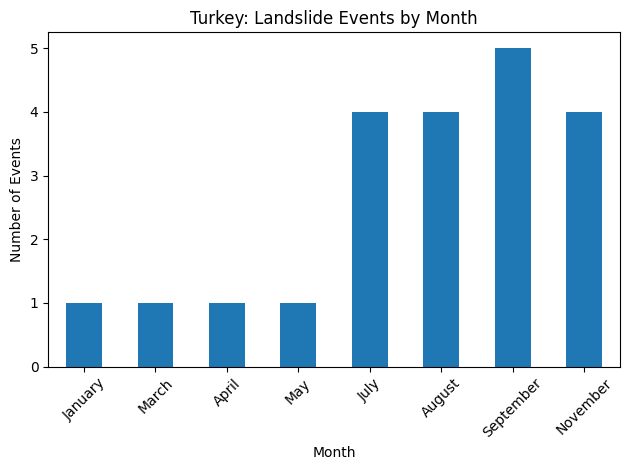

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

monthly_counts = (tur.groupby("month", as_index=False)
                    .size().rename(columns={"size":"events"}))
monthly_counts["month_name"] = pd.to_datetime(monthly_counts["month"], format="%m").dt.month_name()

display(monthly_counts.sort_values("month"))

plt.figure()
monthly_counts.sort_values("month").plot(x="month_name", y="events", kind="bar", legend=False, rot=45)
plt.title("Turkey: Landslide Events by Month")
plt.xlabel("Month"); plt.ylabel("Number of Events")
plt.tight_layout(); plt.show()

plt.savefig("monthly_landslides.png", dpi=300)  # saves in high quality
plt.show()


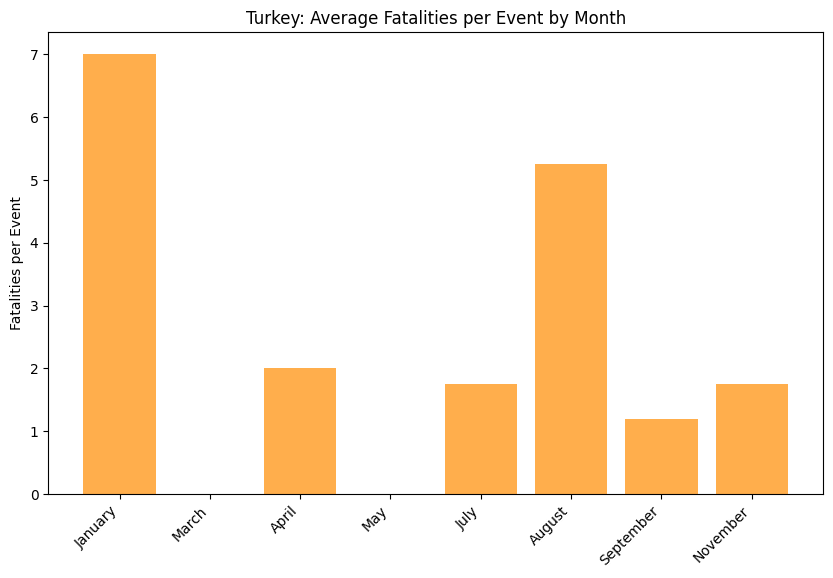

,month,events,fatalities,fatalities_per_event,month_name
0,1,1,7,7.00,January
1,3,1,0,0.00,March
2,4,1,2,2.00,April
3,5,1,0,0.00,May
4,7,4,7,1.75,July
5,8,4,21,5.25,August
6,9,5,6,1.20,September
7,11,4,7,1.75,November


In [10]:
monthly_risk = tur.groupby("month").agg(
    events=("event_dt", "count"),
    fatalities=(fatal_col, "sum")   # ✅ no quotes around fatal_col
).reset_index()

monthly_risk["fatalities_per_event"] = monthly_risk["fatalities"] / monthly_risk["events"]
monthly_risk["month_name"] = pd.to_datetime(monthly_risk["month"], format="%m").dt.month_name()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(monthly_risk["month_name"], monthly_risk["fatalities_per_event"], color="darkorange", alpha=0.7)
plt.title("Turkey: Average Fatalities per Event by Month")
plt.ylabel("Fatalities per Event")
plt.xticks(rotation=45, ha="right")
plt.show()

monthly_risk

In [23]:
fatal_by_trigger = (tur
    .groupby(trigger_col, as_index=False)
    .agg(events=("event_dt","count"),
         fat_sum=(fatal_col,"sum"),
         fat_mean=(fatal_col,"mean"),
         fat_median=(fatal_col,"median"),
         pct_events_with_fatalities=(fatal_col, lambda s: (s>0).mean()*100))
    .sort_values(["fat_sum","events"], ascending=False)
)
fatal_by_trigger.head(10)


,landslide_trigger,events,fat_sum,fat_mean,fat_median,pct_events_with_fatalities
0,downpour,11,34,3.090909,3.0,72.727273
1,rain,8,15,1.875000,1.5,75.000000
2,unknown,2,1,0.500000,0.5,50.000000


<Figure size 640x480 with 0 Axes>

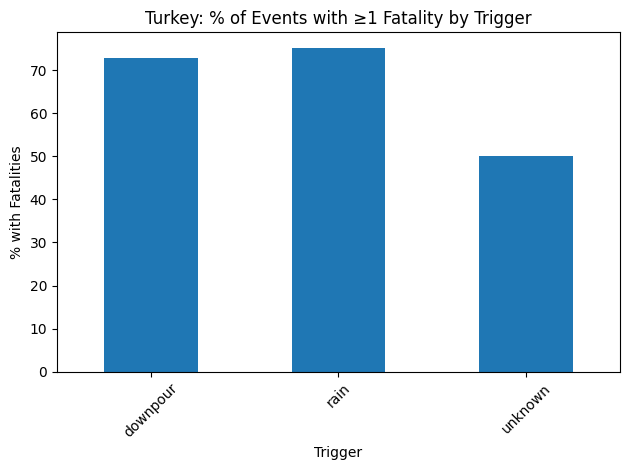

In [24]:
plt.figure()
fatal_by_trigger.plot(x=trigger_col, y="pct_events_with_fatalities", kind="bar", legend=False, rot=45)
plt.title("Turkey: % of Events with ≥1 Fatality by Trigger")
plt.xlabel("Trigger"); plt.ylabel("% with Fatalities")
plt.tight_layout(); plt.show()


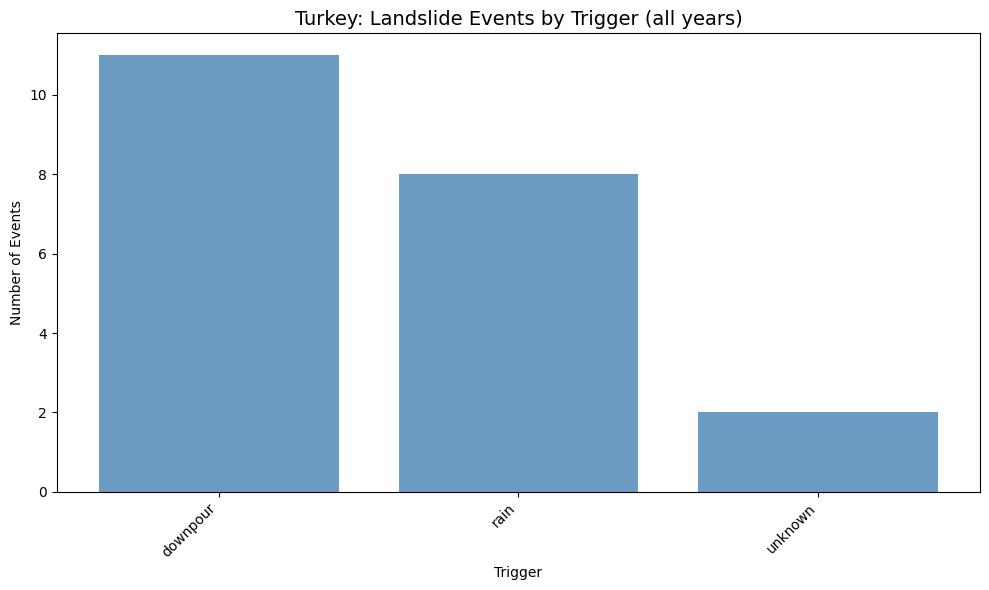

,landslide_trigger,events
0,downpour,11
1,rain,8
2,unknown,2


In [13]:
import matplotlib.pyplot as plt

# --- Group by trigger: count number of events ---
trigger_events = (tur.groupby("landslide_trigger", as_index=False)
                    .agg(events=("event_dt","count"))
                    .sort_values("events", ascending=False))

# --- Plot ---
plt.figure(figsize=(10,6))
plt.bar(trigger_events["landslide_trigger"], trigger_events["events"], color="steelblue", alpha=0.8)
plt.title("Turkey: Landslide Events by Trigger (all years)", fontsize=14)
plt.xlabel("Trigger")
plt.ylabel("Number of Events")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

trigger_events

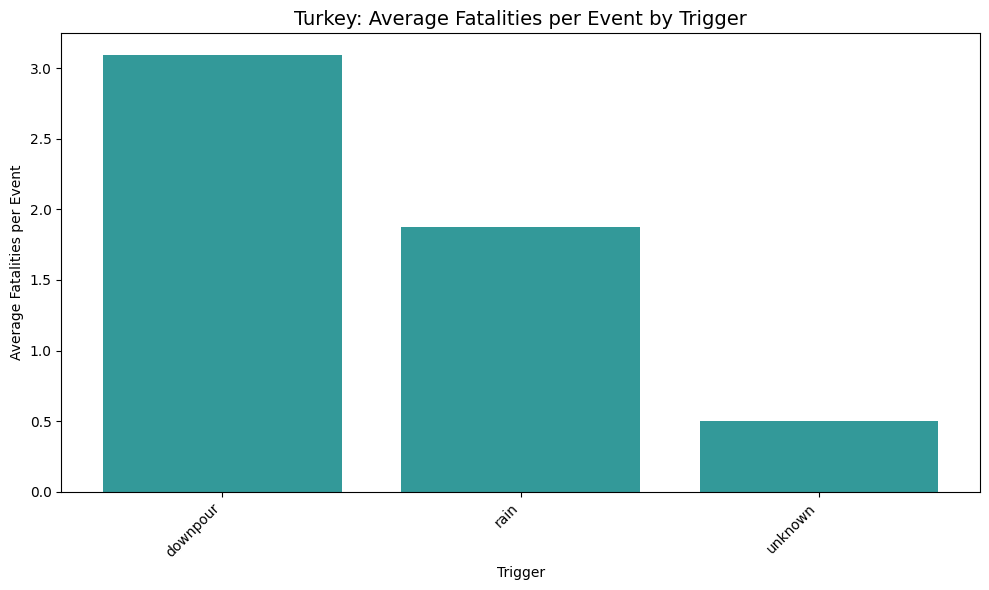

,landslide_trigger,avg_fatalities
0,downpour,3.090909
1,rain,1.875000
2,unknown,0.500000


In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure fatalities are numeric
tur["fatality_count"] = pd.to_numeric(tur["fatality_count"], errors="coerce").fillna(0)

# Group by trigger and calculate mean fatalities
avg_fatalities = (tur.groupby("landslide_trigger", as_index=False)
                    .agg(avg_fatalities=("fatality_count", "mean"))
                    .sort_values("avg_fatalities", ascending=False))

# Plot
plt.figure(figsize=(10,6))
plt.bar(avg_fatalities["landslide_trigger"], avg_fatalities["avg_fatalities"], color="teal", alpha=0.8)
plt.title("Turkey: Average Fatalities per Event by Trigger", fontsize=14)
plt.xlabel("Trigger")
plt.ylabel("Average Fatalities per Event")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Display table for reference
avg_fatalities

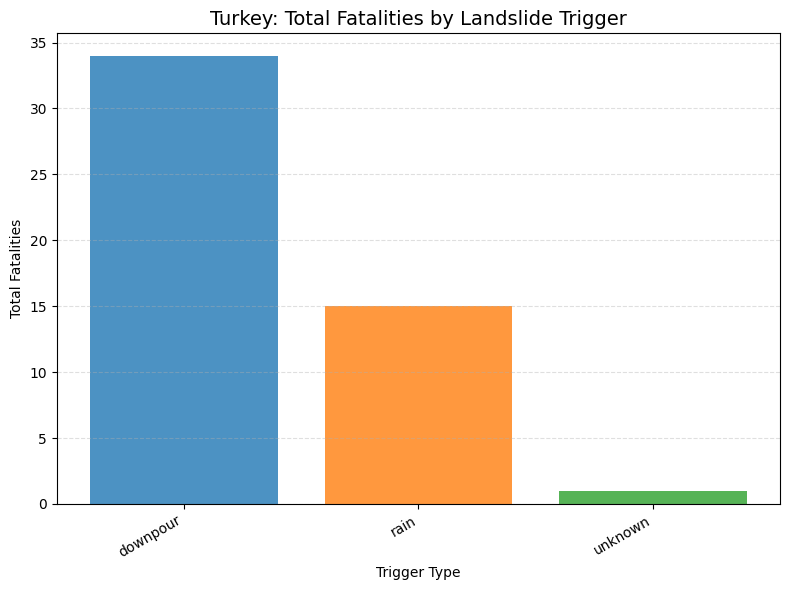

,landslide_trigger,total_fatalities
0,downpour,34
1,rain,15
2,unknown,1


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure fatalities are numeric
tur["fatality_count"] = pd.to_numeric(tur["fatality_count"], errors="coerce").fillna(0)

# Group by trigger and sum fatalities
fatal_by_trigger = (tur.groupby("landslide_trigger", as_index=False)
                      .agg(total_fatalities=("fatality_count", "sum"))
                      .sort_values("total_fatalities", ascending=False))

# Plot
plt.figure(figsize=(8,6))
plt.bar(fatal_by_trigger["landslide_trigger"], fatal_by_trigger["total_fatalities"],
        color=["#1f77b4", "#ff7f0e", "#2ca02c"], alpha=0.8)
plt.title("Turkey: Total Fatalities by Landslide Trigger", fontsize=14)
plt.xlabel("Trigger Type")
plt.ylabel("Total Fatalities")
plt.xticks(rotation=30, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Display table for reference
display(fatal_by_trigger)


In [31]:
import pandas as pd
import numpy as np

values = [0, 0, 1, 3, 4, 6, 8, 12]
s = pd.Series(values)

# pandas' default quantiles (linear interpolation)
print("Pandas default quantiles (linear interpolation):")
print(s.quantile([0.25, 0.5, 0.75]))

# Manual linear interpolation for verification
def linear_quantile(x, q):
    x = np.sort(x)
    n = len(x)
    h = 1 + (n - 1) * q
    j = int(np.floor(h))
    gamma = h - j
    if j >= n:
        return x[-1]
    return x[j - 1] + gamma * (x[j] - x[j - 1])

manual = {p: linear_quantile(values, p) for p in [0.25, 0.5, 0.75]}
print("\nManual linear interpolation quantiles:")
print(manual)


Pandas default quantiles (linear interpolation):
0.25    0.75
0.50    3.50
0.75    6.50
dtype: float64

Manual linear interpolation quantiles:
{0.25: np.float64(0.75), 0.5: np.float64(3.5), 0.75: np.float64(6.5)}


/tmp/ipython-input-1238243985.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(triggers, labels=labels, showfliers=True)


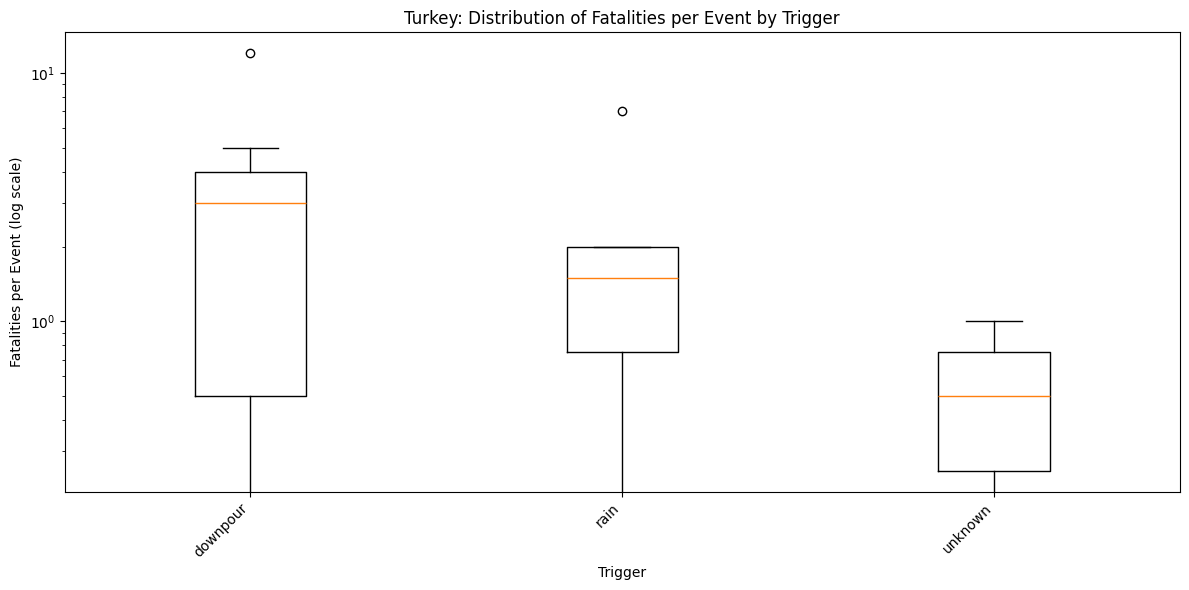

In [32]:
import matplotlib.pyplot as plt

# Make sure fatalities are numeric
tur["fatality_count"] = pd.to_numeric(tur["fatality_count"], errors="coerce").fillna(0)

# Prepare data
triggers = []
labels = []
for trig, group in tur.groupby("landslide_trigger"):
    vals = group["fatality_count"].dropna().values
    if len(vals) > 0:
        triggers.append(vals)
        labels.append(trig)

# Plot boxplots
plt.figure(figsize=(12,6))
plt.boxplot(triggers, labels=labels, showfliers=True)
plt.yscale("log")  # log scale to handle large fatal events
plt.ylabel("Fatalities per Event (log scale)")
plt.xlabel("Trigger")
plt.title("Turkey: Distribution of Fatalities per Event by Trigger")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [33]:
import pandas as pd

# Make sure fatalities are numeric
tur["fatality_count"] = pd.to_numeric(tur["fatality_count"], errors="coerce").fillna(0)

# Compute descriptive stats by trigger
boxplot_stats = (tur.groupby("landslide_trigger")["fatality_count"]
                   .describe(percentiles=[0.25,0.5,0.75])
                   .rename(columns={
                       "25%":"Q1",
                       "50%":"Median",
                       "75%":"Q3"
                   })
                   .reset_index())

# Round for nicer display
boxplot_stats = boxplot_stats[["landslide_trigger","count","min","Q1","Median","Q3","max","mean","std"]].round(2)

boxplot_stats


,landslide_trigger,count,min,Q1,Median,Q3,max,mean,std
0,downpour,11.0,0.0,0.50,3.0,4.00,12.0,3.09,3.48
1,rain,8.0,0.0,0.75,1.5,2.00,7.0,1.88,2.23
2,unknown,2.0,0.0,0.25,0.5,0.75,1.0,0.50,0.71


In [34]:
# Which years are in the Turkey subset?
years_in_data = sorted(tur["year"].unique())
print("Years in Turkish landslide dataset:", years_in_data)

# Also show how many events per year
events_per_year = tur.groupby("year").size().reset_index(name="events")
display(events_per_year)


Years in Turkish landslide dataset: [np.int32(2007), np.int32(2008), np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016)]


,year,events
0,2007,1
1,2008,2
2,2009,4
3,2010,1
4,2011,1
5,2013,3
6,2014,2
7,2015,5
8,2016,2


In [35]:
import pandas as pd

def pick(colnames, df):
    for c in colnames:
        if c in df.columns: return c
    return None

fatal_col   = fatal_col   if 'fatal_col'   in globals() else pick(["fatality_count","fatalities","fatality","fatalities_count"], tur)
trigger_col = trigger_col if 'trigger_col' in globals() else pick(["trigger","landslide_trigger","landslide__trigger","landslide_trigger_"], tur)
lat_col     = lat_col     if 'lat_col'     in globals() else pick(["latitude","lat"], tur)
lon_col     = lon_col     if 'lon_col'     in globals() else pick(["longitude","lon","long"], tur)

for name,val in {"fatal_col":fatal_col,"trigger_col":trigger_col,"lat_col":lat_col,"lon_col":lon_col}.items():
    print(f"{name}: {val}")
assert all([fatal_col, trigger_col]), "Missing fatal_col or trigger_col."
assert all(c in tur.columns for c in ["event_dt","year","month"]), "Need event_dt/year/month in `tur`."


fatal_col: fatality_count
trigger_col: landslide_trigger
lat_col: latitude
lon_col: longitude


In [36]:
import pandas as pd
import numpy as np

# Make sure fatalities are numeric
tur["fatality_count"] = pd.to_numeric(tur["fatality_count"], errors="coerce").fillna(0)

# Group by province
prov_stats = (tur.groupby("admin_division_name", as_index=False)
                .agg(events=("event_dt","count"),
                     fatalities=("fatality_count","sum")))

# Drop empty province names
prov_stats = prov_stats[prov_stats["admin_division_name"].str.strip().ne("")]

# Compute average fatalities per event
prov_stats["fatalities_per_event"] = prov_stats["fatalities"] / prov_stats["events"]

# Select top provinces by number of events
prov_top = (prov_stats.sort_values("events", ascending=False)
                       .head(12)
                       .sort_values("events", ascending=False))

# Check table before plotting
display(prov_top)


,admin_division_name,events,fatalities,fatalities_per_event
0,Artvin,5,14,2.8
2,Erzurum,2,2,1.0
11,Trabzon,2,3,1.5
6,Istanbul,2,0,0.0
1,Diyarbakır,1,7,7.0
3,Gümüşhane,1,2,2.0
5,Hatay,1,5,5.0
4,Hakkâri,1,0,0.0
8,Rize,1,12,12.0
7,Muğla,1,1,1.0


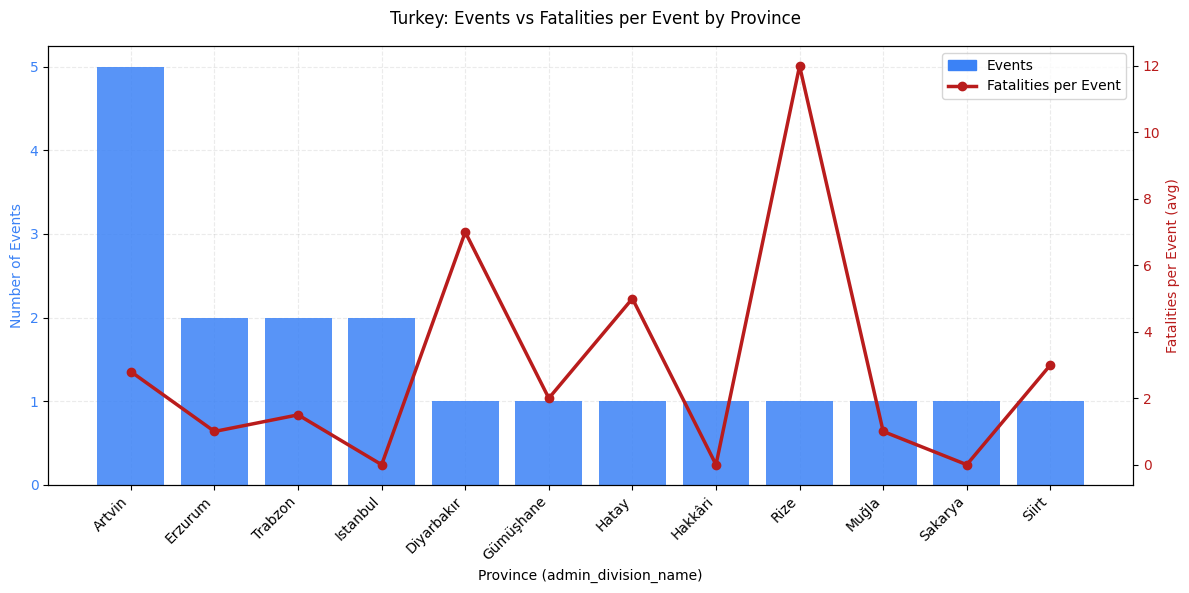

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np

# --- 3) Plot: Events (bars, left axis) + Fatalities per Event (line, right axis) ---
fig, ax1 = plt.subplots(figsize=(12,6))

x = np.arange(len(prov_top))
labels = prov_top["admin_division_name"].tolist()

# Force distinct colors
events_color = "#3b82f6"     # blue
fatal_color  = "#b91c1c"     # red

# Bars = Events (LEFT axis)
bars = ax1.bar(x, prov_top["events"].values, color=events_color, alpha=0.85, zorder=2)
ax1.set_ylabel("Number of Events", color=events_color)
ax1.tick_params(axis="y", labelcolor=events_color)

# Line = Fatalities per Event (RIGHT axis)
ax2 = ax1.twinx()
ax2.plot(x, prov_top["fatalities_per_event"].values, color=fatal_color, marker="o", linewidth=2.5, zorder=3)
ax2.set_ylabel("Fatalities per Event (avg)", color=fatal_color)
ax2.tick_params(axis="y", labelcolor=fatal_color)

# X-axis labels
ax1.set_xlabel("Province (admin_division_name)")
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha="right")

# Grid behind bars/line
ax1.grid(True, linestyle="--", alpha=0.25, zorder=1)

# Title
fig.suptitle("Turkey: Events vs Fatalities per Event by Province", y=0.98)

# Legend (explicit handles so it never guesses)
legend_handles = [
    mpatches.Patch(color=events_color, label="Events"),
    Line2D([0],[0], color=fatal_color, marker="o", linewidth=2.5, label="Fatalities per Event")
]
ax1.legend(handles=legend_handles, loc="upper right")

fig.tight_layout()
plt.show()


In [40]:
import pandas as pd
tur = tur.copy()
tur["fatality_count"] = pd.to_numeric(tur["fatality_count"], errors="coerce").fillna(0)
tur["admin_division_name"] = tur["admin_division_name"].astype(str).str.strip()

prov = (tur.groupby("admin_division_name", as_index=False)
          .agg(events=("event_dt","count"),
               fatalities=("fatality_count","sum")))
prov = prov[prov["admin_division_name"]!=""]  # drop blanks
prov["fatalities_per_event"] = prov["fatalities"] / prov["events"]

# Show the three provinces you mentioned (exact names may vary by dataset)
check = prov[prov["admin_division_name"].isin(["Rize","Diyarbakır","Artvin"])]
display(check)

# Also show top by fatalities_per_event (min events filter avoids 1-off outliers)
display(prov[prov["events"]>=1]
        .sort_values(["fatalities_per_event","events"], ascending=[False,False])
        .head(15)
        .round({"fatalities_per_event":2}))


,admin_division_name,events,fatalities,fatalities_per_event
0,Artvin,5,14,2.8
1,Diyarbakır,1,7,7.0
8,Rize,1,12,12.0


,admin_division_name,events,fatalities,fatalities_per_event
8,Rize,1,12,12.0
1,Diyarbakır,1,7,7.0
5,Hatay,1,5,5.0
10,Siirt,1,3,3.0
0,Artvin,5,14,2.8
3,Gümüşhane,1,2,2.0
11,Trabzon,2,3,1.5
2,Erzurum,2,2,1.0
7,Muğla,1,1,1.0
13,Zonguldak,1,1,1.0


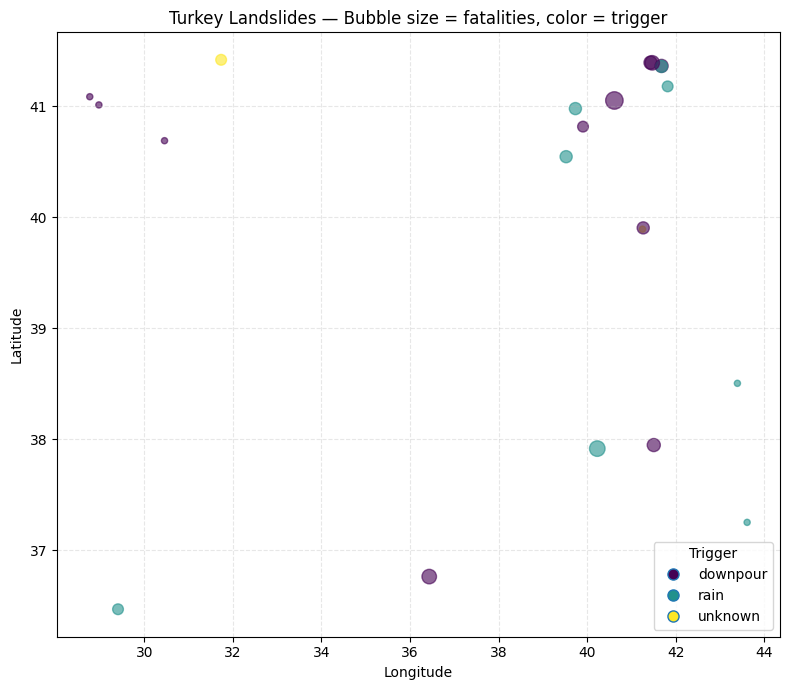

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

geo = tur.copy()
geo["latitude"] = pd.to_numeric(geo["latitude"], errors="coerce")
geo["longitude"] = pd.to_numeric(geo["longitude"], errors="coerce")
geo["fatality_count"] = pd.to_numeric(geo["fatality_count"], errors="coerce").fillna(0)
geo = geo.dropna(subset=["latitude","longitude"])

# Scale bubbles: sqrt keeps big events visible but not overwhelming
sizes = 20 + 40*np.sqrt(geo["fatality_count"].values)

# Color by trigger (simple palette via factorize)
codes, labels = pd.factorize(geo["landslide_trigger"])
plt.figure(figsize=(8,7))
scatter = plt.scatter(geo["longitude"], geo["latitude"], s=sizes, c=codes, alpha=0.6)

# Build legend for triggers
handles = []
for i, lab in enumerate(labels):
    handles.append(plt.Line2D([], [], marker='o', linestyle='', markersize=8,
                              markerfacecolor=scatter.cmap(scatter.norm(i)), label=lab))
plt.legend(handles=handles, title="Trigger", loc="best")

plt.title("Turkey Landslides — Bubble size = fatalities, color = trigger")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [44]:
import pandas as pd
import numpy as np

geo = tur.copy()
geo["latitude"] = pd.to_numeric(geo["latitude"], errors="coerce")
geo["longitude"] = pd.to_numeric(geo["longitude"], errors="coerce")
geo["fatality_count"] = pd.to_numeric(geo["fatality_count"], errors="coerce").fillna(0)
geo = geo.dropna(subset=["latitude", "longitude"])

# Select only relevant columns
geo_table = geo[["event_date", "admin_division_name", "latitude", "longitude", "landslide_trigger", "fatality_count"]]

# Display first few rows
display(geo_table.head(20))


,event_date,admin_division_name,latitude,longitude,landslide_trigger,fatality_count
971,09/23/2009 08:00:00 PM,Artvin,41.3639,41.6822,downpour,3
1155,07/16/2013 08:00:00 AM,Hatay,36.7619,36.4354,downpour,5
1224,08/24/2015 12:00:00 AM,Artvin,41.3936,41.4323,downpour,3
2030,09/09/2008 12:00:00 AM,Siirt,37.9472,41.5061,downpour,3
2319,07/07/2016 11:00:00 PM,Trabzon,40.8167,39.9081,downpour,1
2608,09/09/2009 12:00:00 AM,Istanbul,41.0124,28.9759,downpour,0
2700,03/07/2013 12:00:00 AM,Hakkâri,37.2506,43.6143,rain,0
2780,11/21/2009 12:00:00 AM,Trabzon,40.9792,39.7365,rain,2
2958,01/27/2013 12:00:00 AM,Diyarbakır,37.9152,40.2306,rain,7
3406,09/28/2008 12:00:00 AM,Sakarya,40.6900,30.4580,downpour,0
